In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_curve, auc, recall_score, precision_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
WORK_DIR = '/content/drive/My Drive/Dataset/'

CLASSES = [ 'normal', 'glaucoma', 'diabetic_retinopathy', 'cataract'
           ]

IMG=224

IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )

model_acc={}
model_val_acc={}

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = IDG(rescale=1./255,
              rotation_range=20,
              width_shift_range=0.2,
              height_shift_range=0.2,
              zoom_range=[0.8, 1.2],
              horizontal_flip=True,
              data_format=DATA_FORMAT, 
              fill_mode=FILL_MODE)
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=4237, shuffle=True)
# get image lables
labels =dict(zip([0,1,2,3], CLASSES))
# get a batch of images
train_data, train_labels = train_data_gen.next()

Found 4237 images belonging to 4 classes.


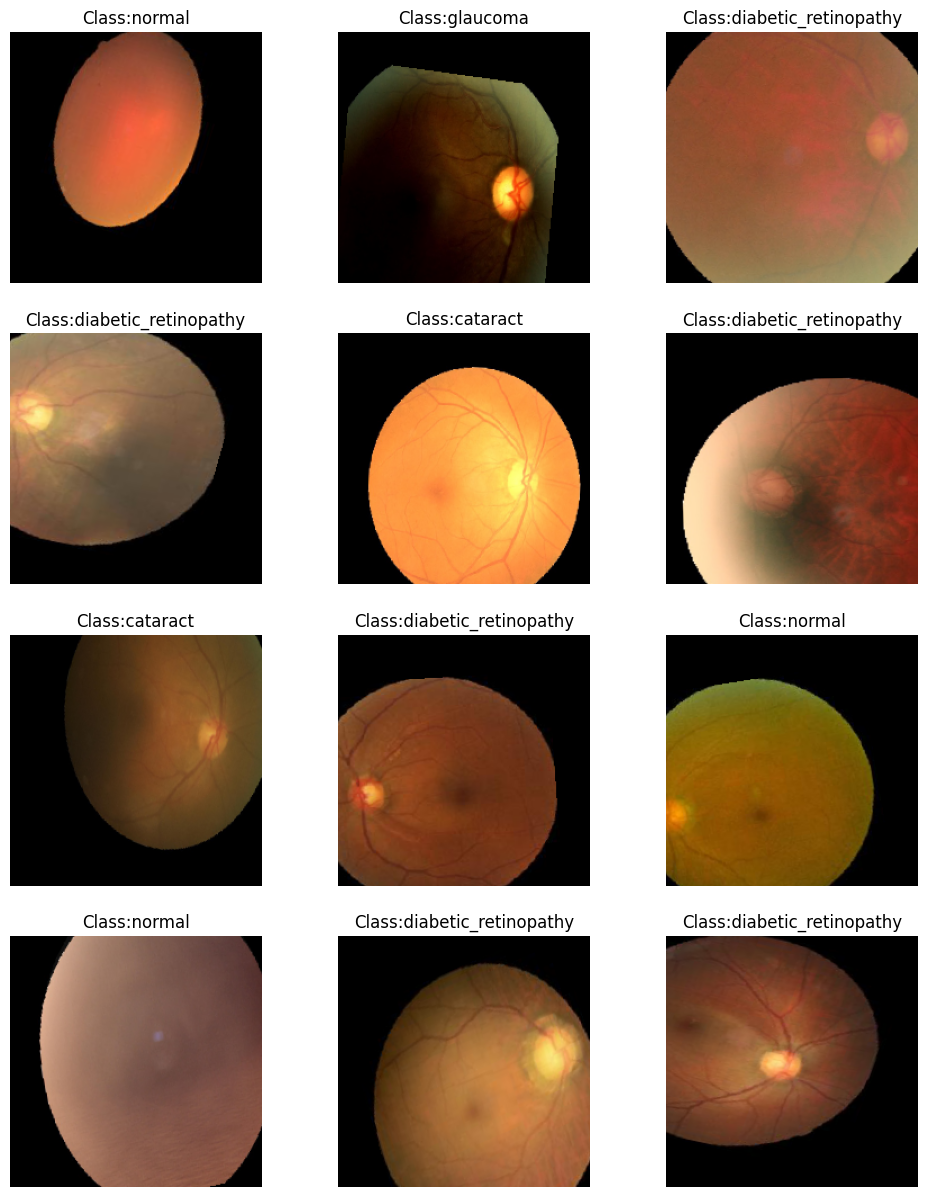

In [ ]:
from random import randint  
# display a grid of 9 images
plt.figure(figsize=(12, 15))
for i in range(12):
  ax = plt.subplot(4, 3, i + 1)
  idx = randint(0,4237)
  plt.imshow(train_data[idx])
  plt.axis("off")
  plt.title("Class:{}".format(labels[np.argmax(train_labels[idx])]))

In [ ]:
print(train_data.shape, train_labels.shape)

(4237, 224, 224, 3) (4237, 4)


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

baseModel = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))


87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define the number of classes
NUM_CLASSES = 4

# Load the pre-trained base model
baseModel = InceptionV3(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)

# Create the model
model_1 = Model(inputs=baseModel.input, outputs=headModel)

# Set the pre-trained layers to be non-trainable
for layer in baseModel.layers:
    layer.trainable = False

# Define the optimizer, loss function and metrics to be used
optimizer = Adam(lr=1e-4, decay=1e-4 / 20)
loss = CategoricalCrossentropy()
metrics = ["acc"]

# Compile the model
model_1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Print the model summary
model_1.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
#Defining other parameters for our CNN model
model_1.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=["acc"])

model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
EPOCHS = 10
history1 = model_1.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/50
106/106 [==============================] - 526s 5s/step - loss: 1.0099 - acc: 0.5571 - val_loss: 0.8288 - val_acc: 0.6403
Epoch 2/50
106/106 [==============================] - 509s 5s/step - loss: 0.8330 - acc: 0.6524 - val_loss: 0.7879 - val_acc: 0.6792
Epoch 3/50
106/106 [==============================] - 507s 5s/step - loss: 0.7534 - acc: 0.7026 - val_loss: 0.6983 - val_acc: 0.7123
Epoch 4/50
106/106 [==============================] - 495s 5s/step - loss: 0.6901 - acc: 0.7300 - val_loss: 0.6648 - val_acc: 0.7264
Epoch 5/50
106/106 [==============================] - 442s 4s/step - loss: 0.6720 - acc: 0.7383 - val_loss: 0.6658 - val_acc: 0.7453
Epoch 6/50
106/106 [==============================] - 500s 5s/step - loss: 0.6391 - acc: 0.7530 - val_loss: 0.6735 - val_acc: 0.7241
Epoch 7/50
106/106 [==============================] - 500s 5s/step - loss: 0.6049 - acc: 0.7645 - val_loss: 0.6456 - val_acc: 0.7476
Epoch 8/50
 35/106 [========>.....................] - ETA: 4:02 - los